In [1]:
%load_ext autoreload
%autoreload

In [97]:
import sys
sys.path.append('../../src')

import pickle
from explainer.explainer import Explainer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from explainer.single_variable_explainer import SingleVariableExplainer

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR

In [3]:
model = pickle.load(open('model/model.pkl', 'rb'))
training_data = pickle.load(open('model/training_data.pkl', 'rb'))

In [4]:
explainer = Explainer(
    model,
    training_data,
    'target',
    regressor='linear',
    bounding_method='quantile',
)

In [5]:
results = []

In [6]:
results.append(explainer.explain(training_data.iloc[1], additional_threshold=-0.25))

  8%|▊         | 59/784 [09:38<1:58:25,  9.80s/it]


In [7]:
results.append(explainer.explain(training_data.iloc[1]))

  8%|▊         | 64/784 [10:07<1:53:57,  9.50s/it]


In [8]:
results.append(explainer.explain(training_data.iloc[1], additional_threshold=0.25))

  0%|          | 0/784 [00:00<?, ?it/s]

  9%|▉         | 70/784 [11:38<1:58:44,  9.98s/it]


In [9]:
def plot_with_changes_highlighted(
    ax,
    original,
    result_object,
    model
):
    new = result_object[1].explanation_point
    new[result_object[1].explainable_variable] = result_object[1].get_arg_extrema()
    new = np.array(new).astype(np.float32)

    if type(original) is not np.ndarray:
        original = np.array(original).astype(np.float32)

    new_unchanged = new.copy()
    new_larger = new.copy()
    new_smaller = new.copy()
    
    new_unchanged[original != new] = np.nan # Only plot if it's the same
    new_larger[original >= new] = np.nan # Only plot if it's larger
    new_smaller[original <= new] = np.nan # Only plot if it's smaller

    ax.imshow(
        np.array(new_unchanged[:-1]).reshape(28, 28),
        cmap='binary',
    )

    ax.imshow(
        np.array(new_larger[:-1]).reshape(28, 28),
        cmap='Greens',
    )

    ax.imshow(
        np.array(new_smaller[:-1]).reshape(28, 28),
        cmap='Reds',
    )

    def highlight_cell(x, y, ax, color):
        ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor=color, lw=2))
    
    for i in range(28):
        for j in range(28):
            if not np.isnan(new_larger[i * 28 + j]):
                highlight_cell(j, i, ax, 'g')
            if not np.isnan(new_smaller[i * 28 + j]):
                highlight_cell(j, i, ax, 'r')

    ax.set_xlabel(
        f'Classified as {model.predict(pd.DataFrame(new[:-1]).T)[0]} with\nprobability {model.predict_proba(pd.DataFrame(new[:-1]).T).max():.2f}',
        fontsize=36,
    )

    print(sum(original != new))
    return new



def plot_arrow(
    ax
):  
    ax.arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color='k')
    ax.set_ylim([0, 1])

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sk

59
5
5


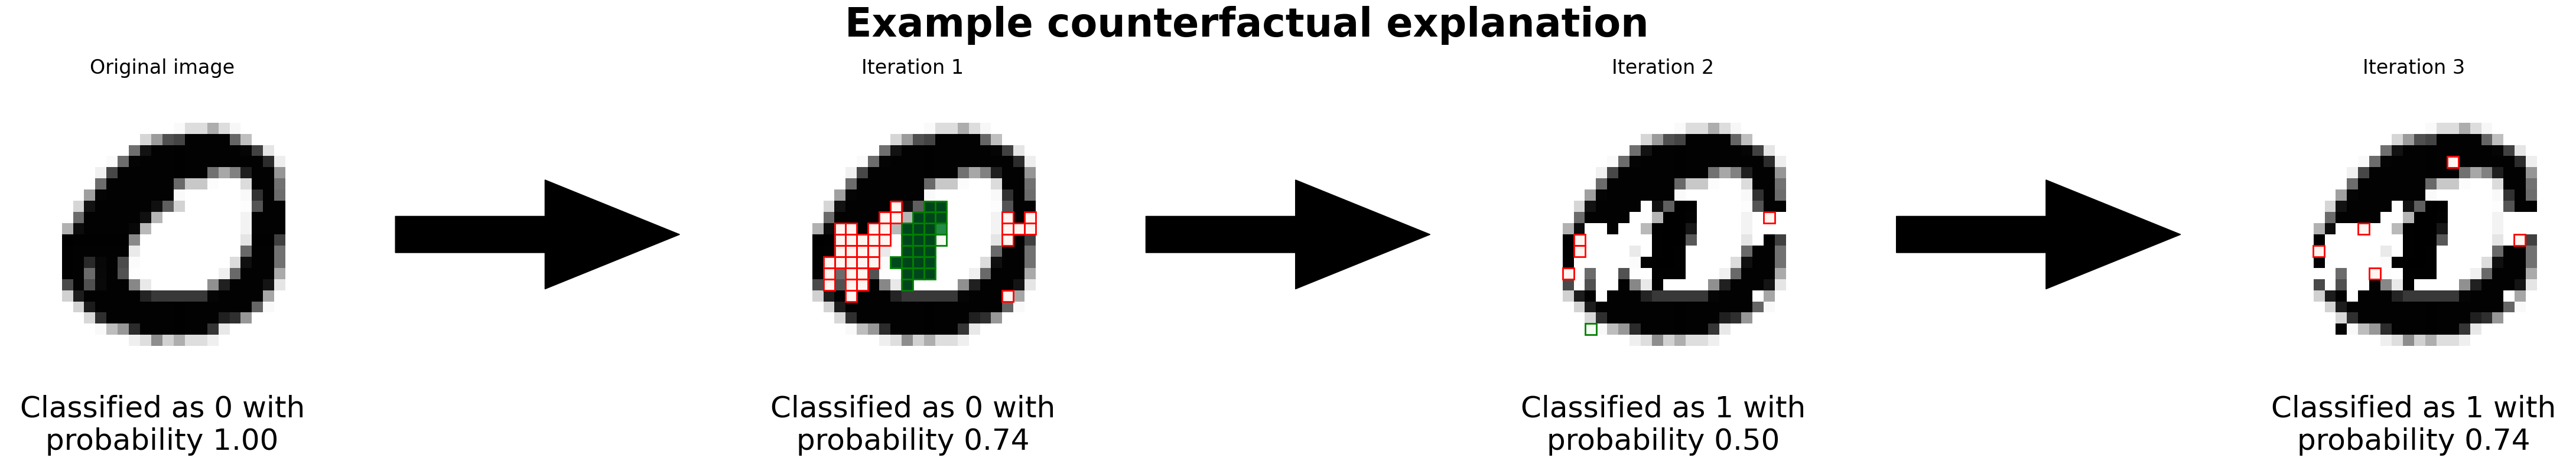

In [10]:
n=len(results)
subplots = 2*n+1
res = 8
fig, axs = plt.subplots(1, subplots, figsize=(res*subplots, res))
plt.suptitle('Example counterfactual explanation\n\n',weight='bold', fontsize=48)

axs[0].imshow(np.array(training_data.iloc[1][:-1]).astype(np.float32).reshape(28, 28), cmap='binary')
axs[0].set_title('Original image', fontsize=24)
axs[0].set_xlabel(
    f'Classified as {model.predict(pd.DataFrame(np.array(training_data.iloc[1]).astype(np.float32)[:-1]).T)[0]} with\nprobability {model.predict_proba(pd.DataFrame(np.array(training_data.iloc[1]).astype(np.float32)[:-1]).T).max():.2f}',
    fontsize=36,
)

axs[0].set_xticks([])
axs[0].set_yticks([])
for spine in axs[0].spines:
    axs[0].spines[spine].set_visible(False)

working_new = training_data.iloc[1]
for i in range(1, subplots-1, 2):
    plot_arrow(axs[i])
    working_new = plot_with_changes_highlighted(axs[i+1], working_new, results[i//2], model)
    axs[i+1].set_title(f'Iteration {i//2 + 1}', fontsize=24)
    for ax in [axs[i], axs[i+1]]:
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)

plt.savefig('../../figures/mnist_counterfactual_example.eps', bbox_inches='tight')
plt.savefig('../../figures/mnist_counterfactual_example.png', bbox_inches='tight')

In [11]:
overall_result = explainer.explain(training_data.iloc[1], additional_threshold=0.49, store_historical_times=True)

  0%|          | 0/784 [00:00<?, ?it/s]

 11%|█▏        | 90/784 [13:21<1:43:04,  8.91s/it]


In [13]:
overall_result[-1]

[9.014277696609497,
 18.988452672958374,
 31.4682559967041,
 41.36084866523743,
 50.9861319065094,
 60.12845993041992,
 70.23038578033447,
 79.73267769813538,
 88.63768076896667,
 97.90033769607544,
 107.56395959854126,
 116.52927279472351,
 125.28380489349365,
 134.12226366996765,
 142.95975279808044,
 151.5803346633911,
 160.13678884506226,
 168.7422525882721,
 177.56790971755981,
 186.03400874137878,
 195.37526488304138,
 205.21376585960388,
 215.00424981117249,
 224.349524974823,
 233.35766577720642,
 242.08278274536133,
 250.86840867996216,
 259.5363907814026,
 268.2995858192444,
 277.8144986629486,
 287.25470066070557,
 297.01631474494934,
 306.76654076576233,
 317.62305784225464,
 327.82753682136536,
 337.5354218482971,
 346.045334815979,
 355.21777081489563,
 364.4153447151184,
 373.7100999355316,
 382.11810994148254,
 391.41034388542175,
 400.3175427913666,
 409.3207149505615,
 418.1356747150421,
 426.74689984321594,
 435.671856880188,
 444.87777376174927,
 453.832457780838,
 

In [37]:
initial_point = training_data.iloc[1][:-1]
initial_classification = int(model.predict(pd.DataFrame(initial_point).T))
working_point = initial_point.copy()
probabilities = [
    model.predict_proba(pd.DataFrame(initial_point).T)[:,1]
]
print(initial_point)
for feature in overall_result[0]:
    sve = SingleVariableExplainer(
        model,
        'target',
        feature,
        working_point,
        training_dataset=training_data,
        regressor='linear',
        bounding_method='quantile',
    )
    working_point[feature] = sve.get_arg_extrema(initial_classification=initial_classification)
    probabilities.append(model.predict_proba(pd.DataFrame(working_point).T)[:,1])

/var/folders/qx/p1n3nbvn2j55yp0mkrpbgngr0000gn/T/ipykernel_4787/3708341911.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  initial_classification = int(model.predict(pd.DataFrame(initial_point).T))


pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 39664, Length: 784, dtype: object


In [38]:
probabilities = [x[0] for x in probabilities]

In [43]:
step_time = pd.DataFrame(overall_result[-1]).diff().values.flatten()

In [44]:
step_time

array([        nan,  9.97417498, 12.47980332,  9.89259267,  9.62528324,
        9.14232802, 10.10192585,  9.50229192,  8.90500307,  9.26265693,
        9.6636219 ,  8.9653132 ,  8.7545321 ,  8.83845878,  8.83748913,
        8.62058187,  8.55645418,  8.60546374,  8.82565713,  8.46609902,
        9.34125614,  9.83850098,  9.79048395,  9.34527516,  9.0081408 ,
        8.72511697,  8.78562593,  8.6679821 ,  8.76319504,  9.51491284,
        9.440202  ,  9.76161408,  9.75022602, 10.85651708, 10.20447898,
        9.70788503,  8.50991297,  9.172436  ,  9.1975739 ,  9.29475522,
        8.40801001,  9.29223394,  8.90719891,  9.00317216,  8.81495976,
        8.61122513,  8.92495704,  9.20591688,  8.95468402,  7.98339891,
        8.42408133,  8.22345495,  8.43715978,  7.77150798,  8.51605296,
        8.73230505,  8.59346914,  8.34936714,  8.47231674,  8.33973789,
        8.10402417,  8.29668808,  8.74478483,  8.07798505,  8.14607406,
        8.25761294,  8.8285439 ,  8.22102714,  8.4553721 ,  8.16

In [67]:
scores = overall_result[-2]

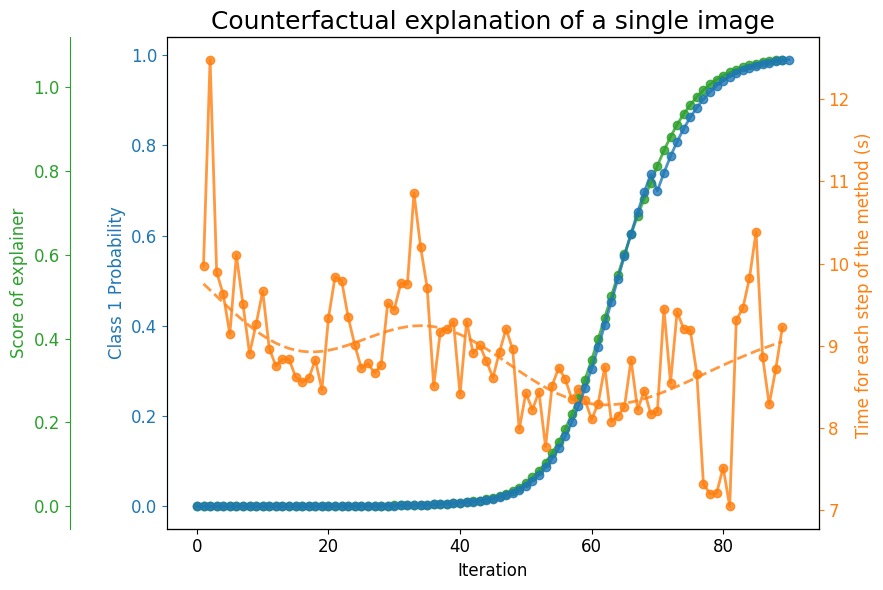

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(probabilities, 'o-', linewidth=2, markersize=6, color='C0', alpha=0.8)

twin_ax = ax.twinx()
twin_ax.plot(step_time, 'o-', linewidth=2, markersize=6, color='C1', alpha=0.8)

twin_ax_2 = ax.twinx()
twin_ax_2.plot(scores, 'o-', linewidth=2, markersize=6, color='C2', alpha=0.8)

twin_ax_2.spines["left"].set_position(("axes", -0.15))
twin_ax_2.spines["left"].set_visible(True)

twin_ax_2.yaxis.set_label_position('left')
twin_ax_2.yaxis.set_ticks_position('left')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Class 1 Probability', fontsize=12)
twin_ax.set_ylabel('Time for each step of the method (s) ', fontsize=12)
twin_ax_2.set_ylabel('Score of explainer', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12)
twin_ax.tick_params(axis='both', which='major', labelsize=12)
twin_ax_2.tick_params(axis='both', which='major', labelsize=12)

fit_train_x = np.arange(len(step_time[1:]))
fit_train_y = step_time[1:]

gpr = SVR()
gpr.fit(fit_train_x.reshape(-1, 1), fit_train_y)
gpr_y_pred = gpr.predict(fit_train_x.reshape(-1, 1))

twin_ax.plot(fit_train_x+1, gpr_y_pred, '--', linewidth=2, color='C1', alpha=0.8)

twin_ax.spines['left'].set_color('C0')
twin_ax.spines['right'].set_color('C1')
ax.yaxis.label.set_color('C0')
ax.tick_params(axis='y', colors='C0')
twin_ax.yaxis.label.set_color('C1')
twin_ax.tick_params(axis='y', colors='C1')
twin_ax_2.spines['left'].set_color('C2')
twin_ax_2.yaxis.label.set_color('C2')
twin_ax_2.tick_params(axis='y', colors='C2')

ax.set_zorder(twin_ax_2.get_zorder()+2)
twin_ax.set_zorder(twin_ax_2.get_zorder()+1)
ax.set_facecolor('none')

ax.set_title('Counterfactual explanation of a single image', fontsize=18)
plt.tight_layout()

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


89


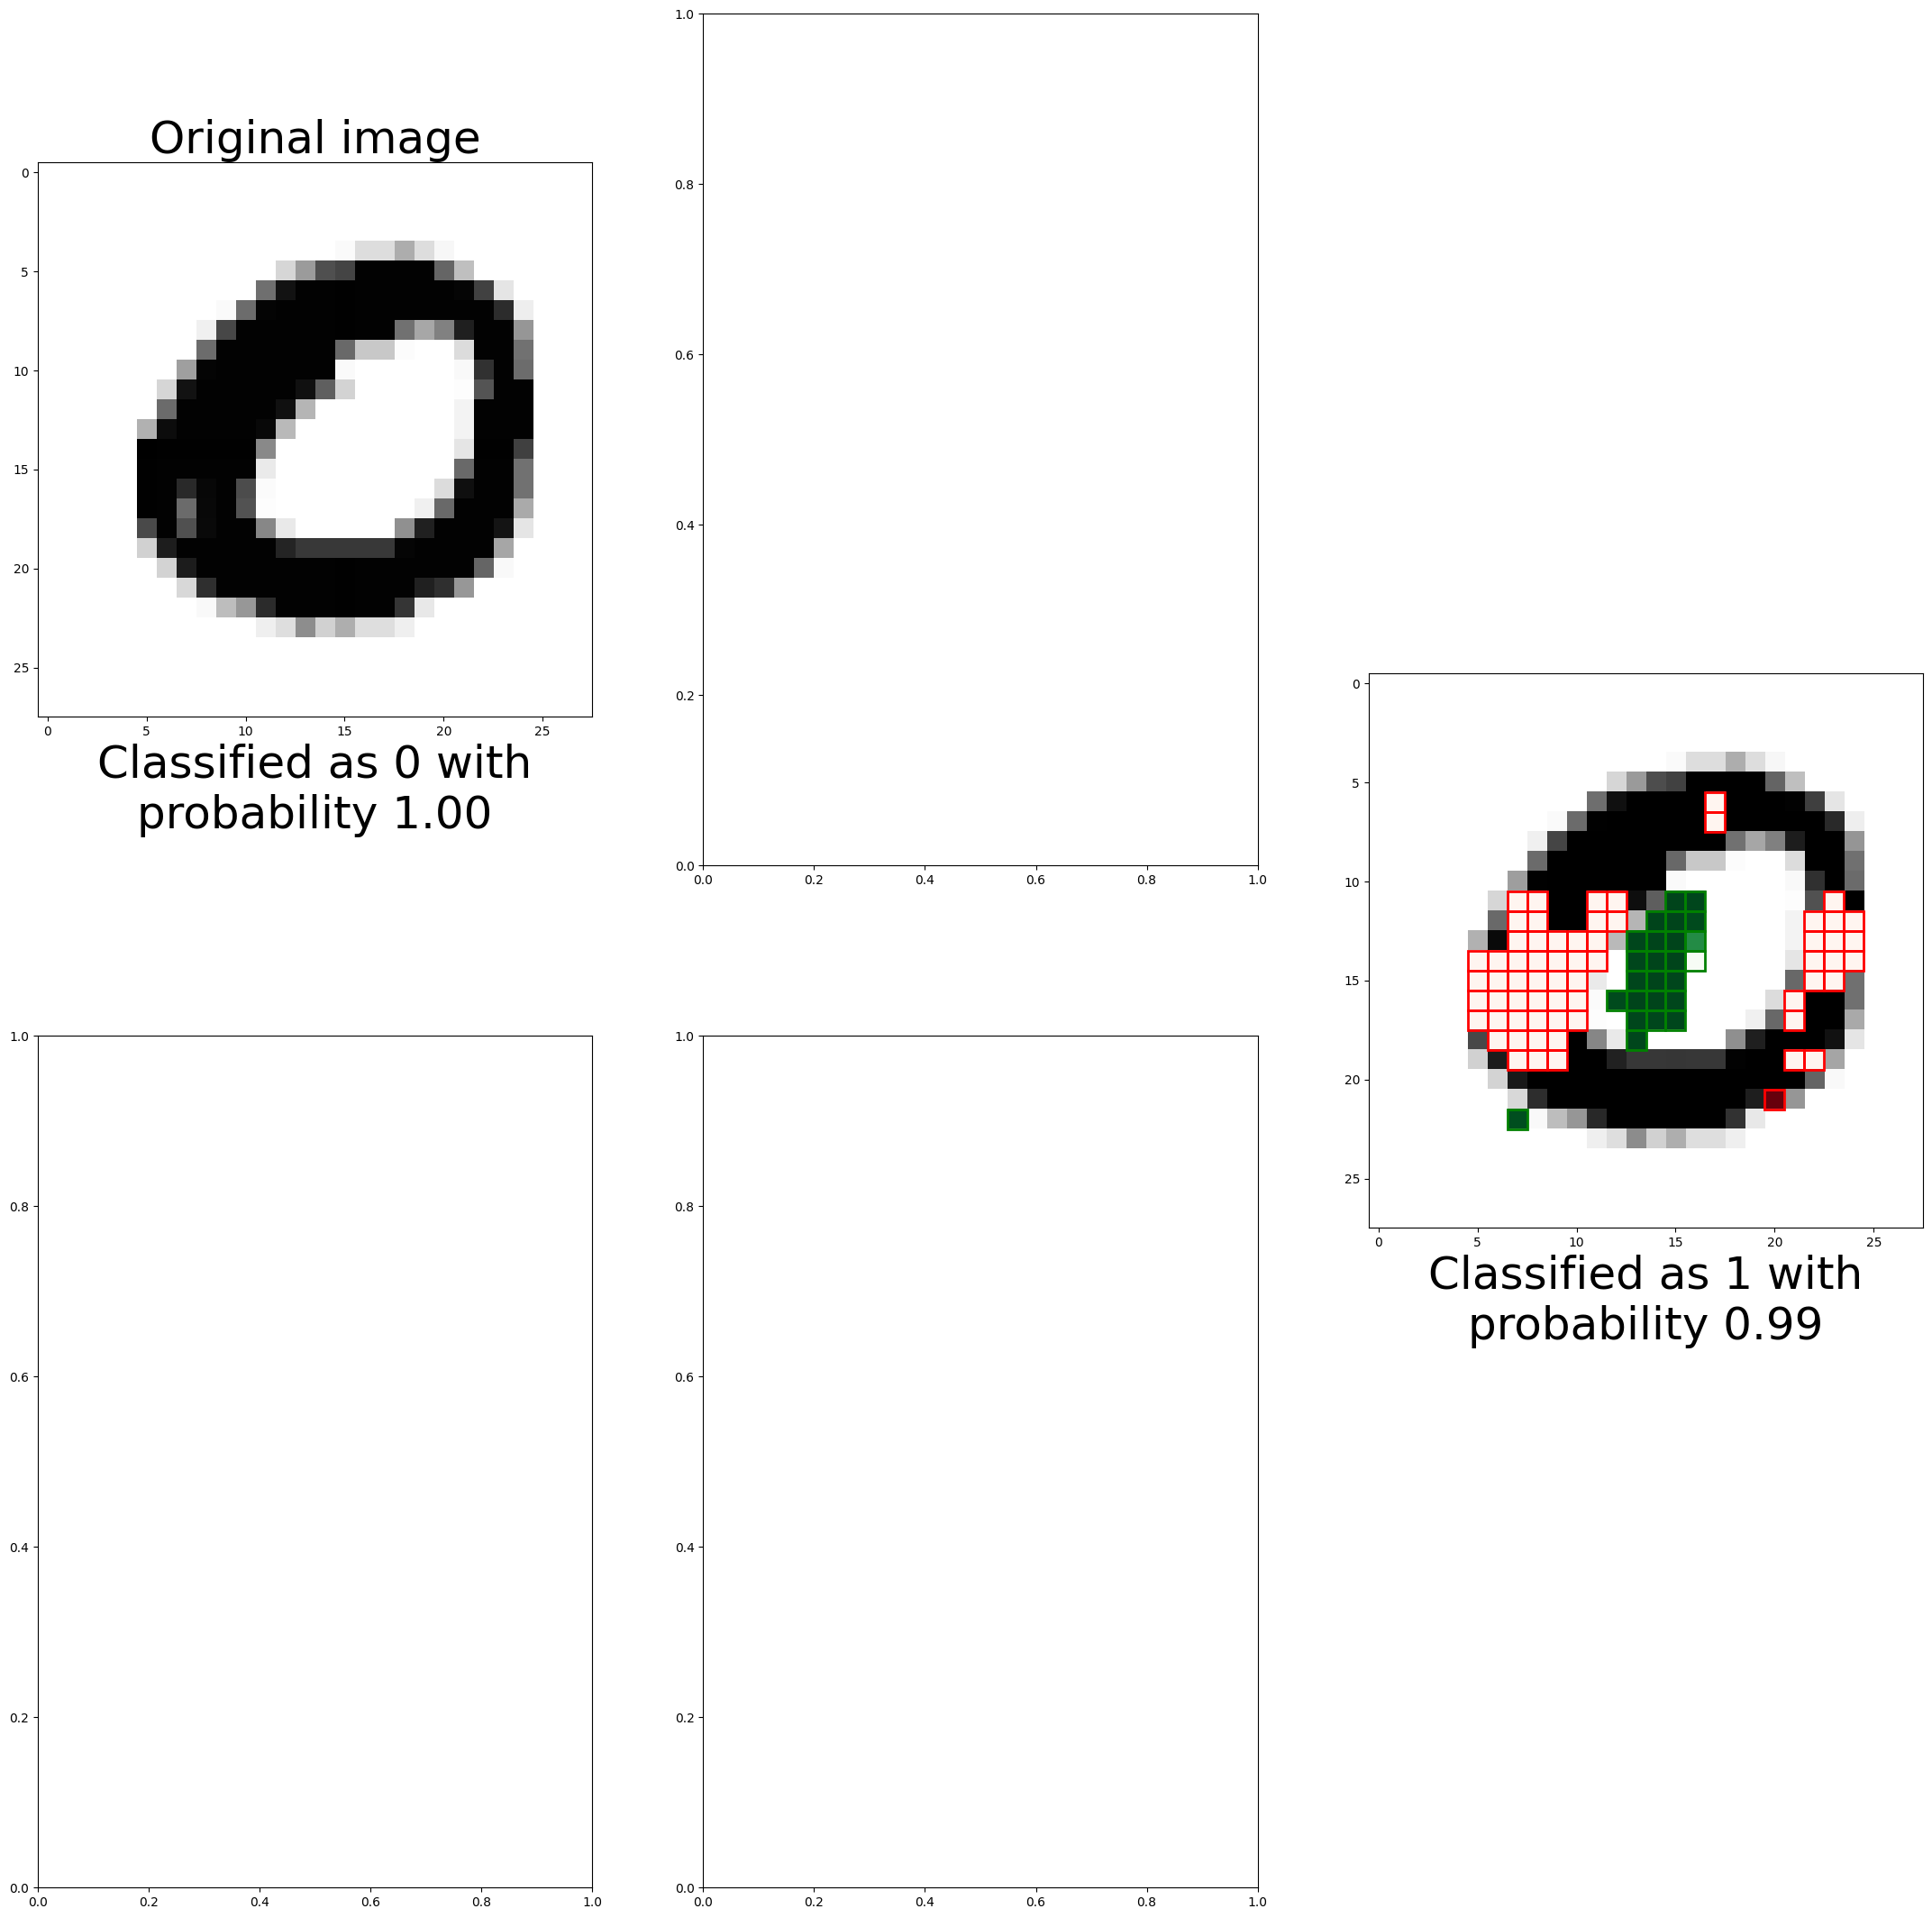

In [118]:
fig, ax = plt.subplots(2, 3, figsize=(27, 27))
ax[0,0].imshow(np.array(training_data.iloc[1][:-1]).astype(np.float32).reshape(28, 28), cmap='binary')
ax[0,0].set_title('Original image', fontsize=36)
ax[0,0].set_xlabel(
    f'Classified as {model.predict(pd.DataFrame(np.array(training_data.iloc[1]).astype(np.float32)[:-1]).T)[0]} with\nprobability {model.predict_proba(pd.DataFrame(np.array(training_data.iloc[1]).astype(np.float32)[:-1]).T).max():.2f}',
    fontsize=36,
)

gs = ax[1, 2].get_gridspec()
for a in ax[1:, -1]:
    a.remove()
axbig = fig.add_subplot(gs[1:, -1])

# plot_arrow(ax[1])
_ =plot_with_changes_highlighted(ax_, training_data.iloc[1], overall_result, model)

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


89


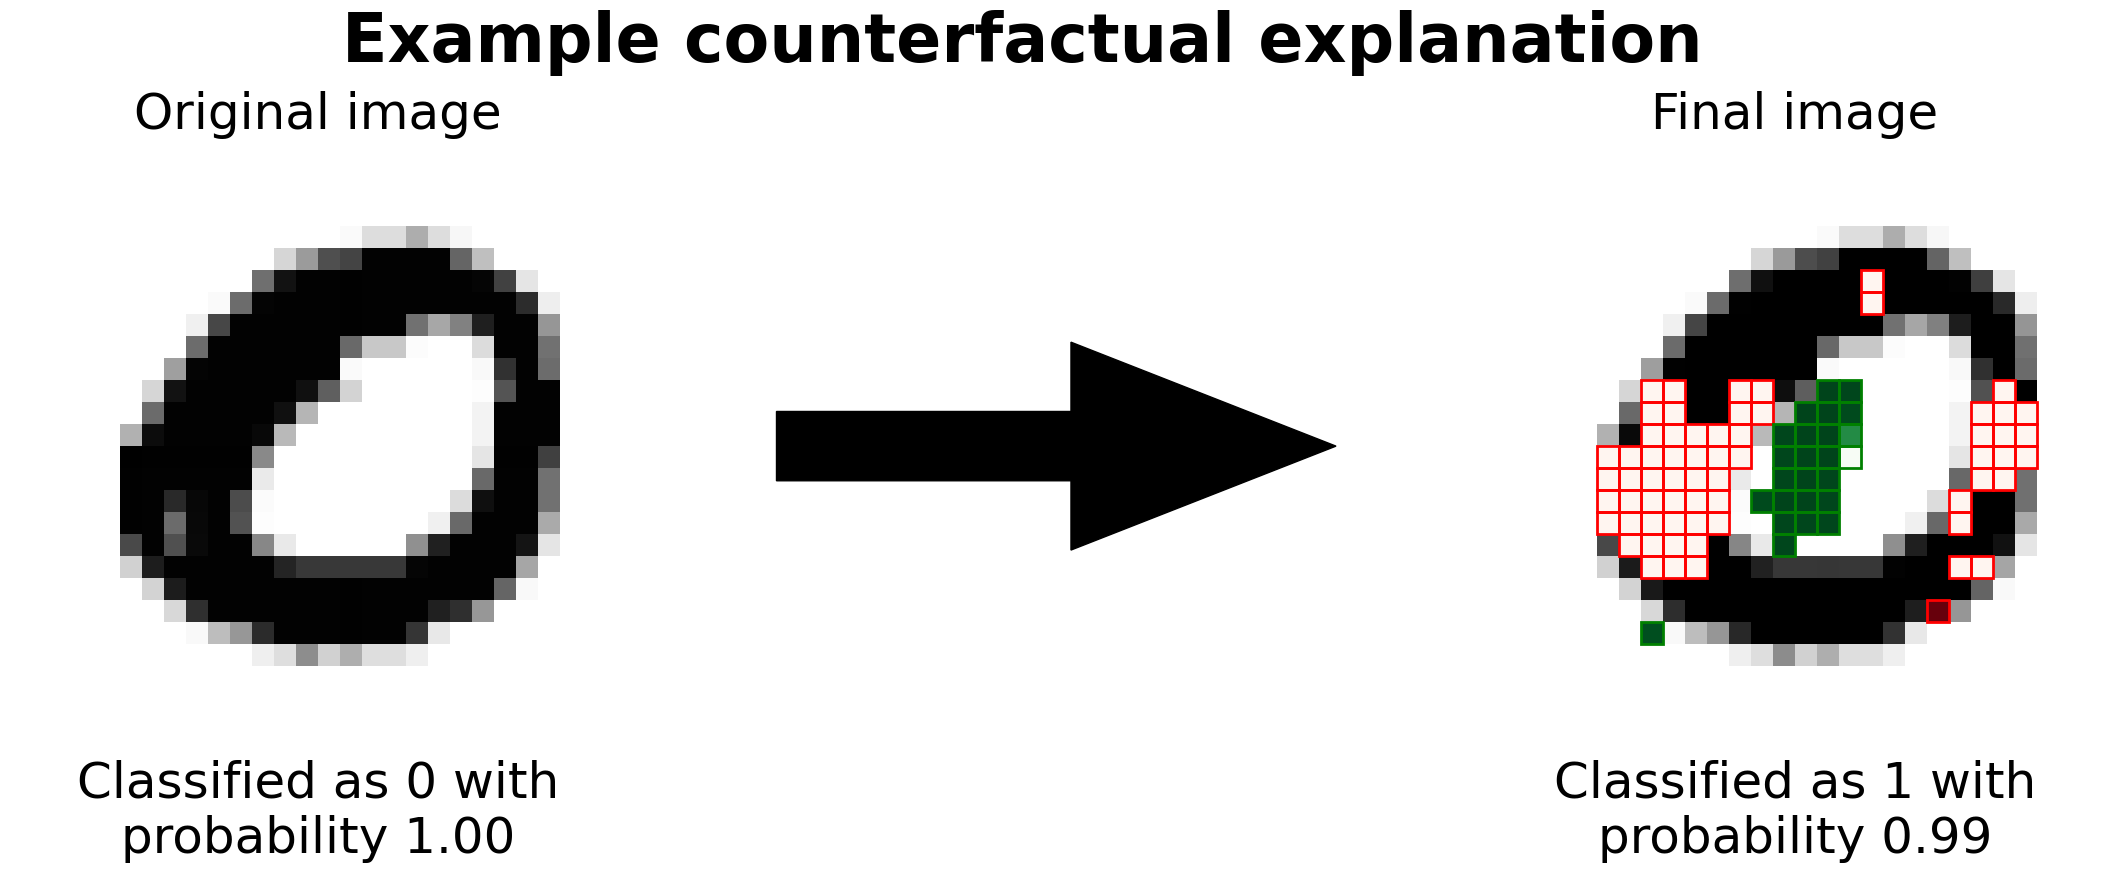

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(27, 9))
ax[0].imshow(np.array(training_data.iloc[1][:-1]).astype(np.float32).reshape(28, 28), cmap='binary')
ax[0].set_title('Original image', fontsize=36)
ax[0].set_xlabel(
    f'Classified as {model.predict(pd.DataFrame(np.array(training_data.iloc[1]).astype(np.float32)[:-1]).T)[0]} with\nprobability {model.predict_proba(pd.DataFrame(np.array(training_data.iloc[1]).astype(np.float32)[:-1]).T).max():.2f}',
    fontsize=36,
)

plot_arrow(ax[1])
_ =plot_with_changes_highlighted(ax[2], training_data.iloc[1], overall_result, model)
ax[2].set_title('Final image', fontsize=36)

for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        for spine in a.spines:
            a.spines[spine].set_visible(False)

plt.suptitle('Example counterfactual explanation\n\n',weight='bold', fontsize=48)

plt.savefig('../../figures/overall_mnist_counterfactual_example.eps', bbox_inches='tight')
plt.savefig('../../figures/overall_mnist_counterfactual_example.png', bbox_inches='tight')